In [1]:
import seaborn as sns
import pandas as pd
import os.path as op
import scipy.signal as sg
import numpy as np
import matplotlib.pyplot as plt

In [2]:
stats_df = pd.read_pickle('/Users/timofej/Desktop/FBLowPreprocessed/P4FBLowClear.pkl')

In [3]:
inf= pd.read_pickle('/Users/timofej/Desktop/FBLowPreprocessed/info_allsubjs.pkl')
inf = inf[['subj_id','fb_type']]

In [4]:
#Only fb blocks
stats_df = stats_df[stats_df['block_number']%2==0][stats_df['block_number']!=4][stats_df['block_number']!=2][stats_df['block_number']!=34][stats_df['block_number']!=36]


/usr/local/Cellar/jupyterlab/1.2.6/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [6]:
# Alpha band filter function
def band_hilbert(x, fs, band, N=None, axis=-1):
    x = np.asarray(x)
    Xf = np.fft.fft(x, N, axis=axis)
    w = np.fft.fftfreq(x.shape[0], d=1. / fs)
    Xf[(w < band[0]) | (w > band[1])] = 0
    x = np.fft.ifft(Xf, axis=axis)
    return 2*x

In [7]:
# Alpha band filter
x = stats_df.P4
FS = 250
band_alpha = [7, 12]
env_alpha = np.abs(band_hilbert(x, FS, band_alpha))

In [ ]:
df = pd.DataFrame(zip(env_alpha, stats_df['subj_id'], stats_df['block_number']),
                   columns=['env_alpha', 'subj_id','block_number'])

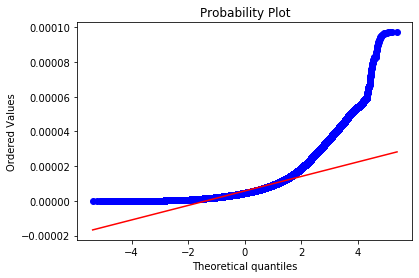

In [46]:
#qqplot befor normalization
import scipy.stats as stats
import pylab  
stats.probplot(df.env_alpha, dist='norm', plot=pylab)
pylab.show()

In [47]:
#Norm for first train block
unique_subj_id = df.subj_id.unique()
data = []
for subj_id in unique_subj_id:
    df_h = df.loc[df['subj_id']==subj_id, :].groupby(df.block_number).mean()
    sixth = df_h[df_h['block_number'] == 6]['env_alpha'].item()
    df_h['env_alpha_norm'] = df_h.loc[:, 'env_alpha'].div(sixth)
    data.append(df_h)
data = pd.concat(data)

In [131]:
#Norm for mean train block
unique_subj_id = df.subj_id.unique()
data = []
for subj_id in unique_subj_id:
    df_h = df.loc[df['subj_id']==subj_id, :].groupby(df.block_number).mean()
    mean_ = df_h['env_alpha'].mean()
    df_h['env_alpha_norm_mean'] = df_h.loc[:, 'env_alpha'].div(mean_)
    data.append(df_h)
data = pd.concat(data)

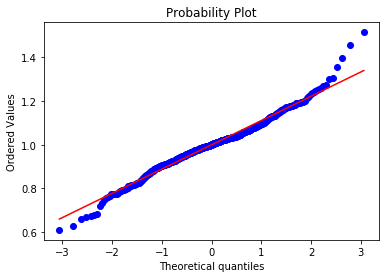

In [133]:
#qqplot after normalization
import scipy.stats as stats
import pylab  
stats.probplot(data.env_alpha_norm_mean, dist='norm', plot=pylab)
pylab.show()

In [160]:
#Box cox transformation
p4 = data.env_alpha_norm_mean.to_numpy() 
p4 = p4.reshape(-1, 1)
from sklearn import preprocessing
data['box_cox']  = preprocessing.power_transform(p4, method='box-cox')
#data['yeo_johnson']  = preprocessing.power_transform(p4, method='yeo-johnson')

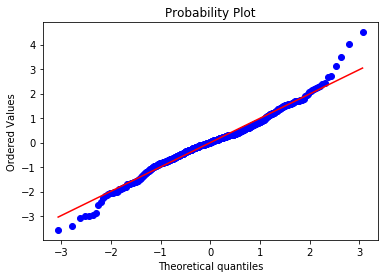

In [161]:
#qqplot after transformation
import scipy.stats as stats
import pylab  
stats.probplot(data.box_cox, dist='norm', plot=pylab)
pylab.show()

In [164]:
#Merge with fb_type
data.add_suffix('_').reset_index()
data = pd.merge(inf, data, on=['subj_id'])

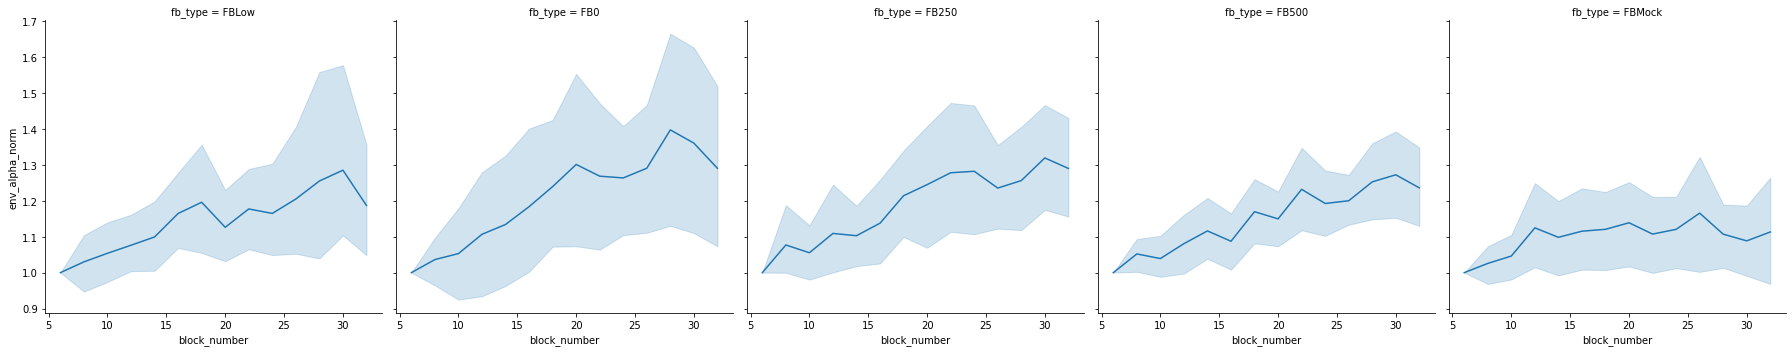

In [52]:
#Relplot for fb type before transform
sns.relplot(x="block_number", y="env_alpha_norm_mean", data=data, col='fb_type', col_order=['FBLow','FB0', 'FB250', 'FB500', 'FBMock'], kind="line")

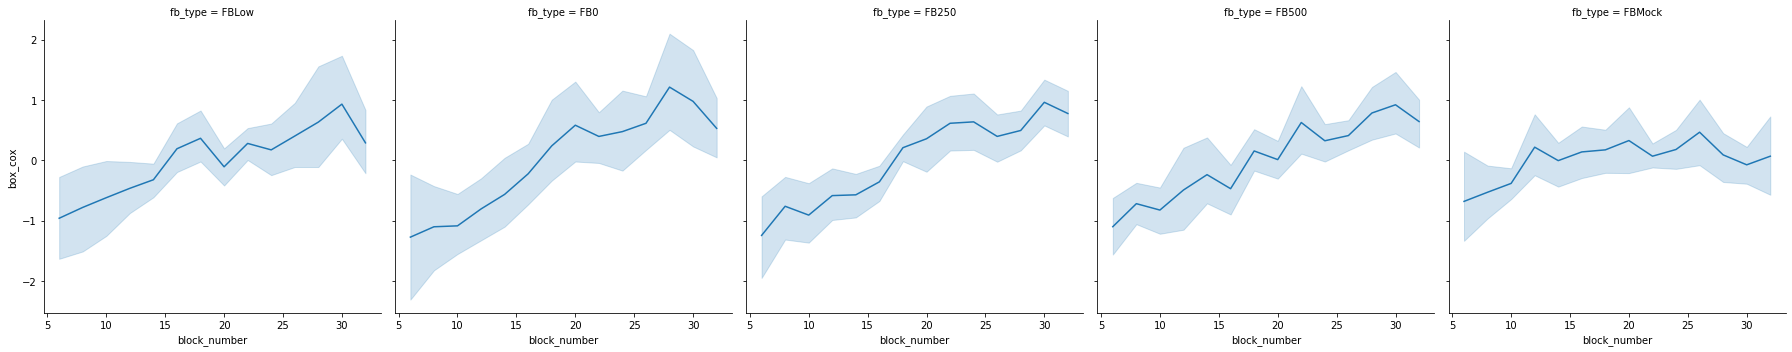

In [165]:
#Relplot for fb type after transform
sns.relplot(x="block_number", y="box_cox", data=data, col='fb_type', col_order=['FBLow','FB0', 'FB250', 'FB500', 'FBMock'], kind="line")

In [170]:
#Linear regres coef 
from scipy import stats
unique_fb_type = data.fb_type.unique()
reg_coef = []
for fb_type in unique_fb_type:
    a = data[data['fb_type'] == fb_type]
    x = a.block_number
    y = a.env_alpha_norm_mean
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    b = []
    b.append(fb_type)
    b.append(slope)
    b.append(intercept)
    b.append(r_value) 
    b.append(p_value) 
    b.append(std_err) 
    reg_coef.append(b)

In [171]:
#Linear regres coef dataframe
reg_coef_df = pd.DataFrame(reg_coef) 
reg_coef_df = reg_coef_df.rename(columns={0: 'fb_type', 1: 'slope', 2: 'intercept', 3: 'r_value', 4: 'p_value', 5: 'std_err'})

In [172]:
#FDR_correction
import statsmodels.sandbox.stats.multicomp as multicomp
pval_corrected = multicomp.multipletests(reg_coef_df['p_value'], method='fdr_bh', alpha=0.3, is_sorted=False, returnsorted=False)[1]
reg_coef_df['pval_corrected'] = list(pval_corrected)

In [173]:
reg_coef_df['R_squared'] = reg_coef_df['r_value']**2 
reg_coef_df

,fb_type,slope,intercept,r_value,p_value,std_err,pval_corrected,R_squared
0,FB0,0.010334,0.803659,0.599298,2.932679e-12,0.001316,4.887799e-12,0.359158
1,FB500,0.008278,0.842718,0.645064,3.570245e-16,0.000881,8.925614e-16,0.416107
2,FB250,0.009047,0.828103,0.658229,9.819333e-19,0.000881,4.909667e-18,0.433265
3,FBMock,0.002645,0.949740,0.259831,5.663863e-03,0.000937,5.663863e-03,0.067512
4,FBLow,0.006712,0.872475,0.465219,6.988742e-09,0.001087,8.735928e-09,0.216428


In [65]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [148]:
a = data[data['fb_type'] == 'FB500']
X = a['block_number'].values.reshape(-1,1)
y = a['env_alpha_norm_mean'].values.reshape(-1,1)

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [150]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [151]:
#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)

[0.84922621]
[[0.00786239]]


In [152]:
y_pred = regressor.predict(X_test)


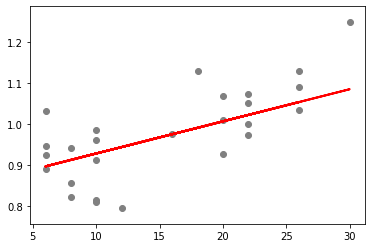

In [153]:
plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

In [154]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.06201683379152715
Mean Squared Error: 0.006063366148634393
Root Mean Squared Error: 0.07786761938466073


In [183]:
# Bartlett sd test
unique_fb_type = data.fb_type.unique()
sd_coef = []
for fb_type in unique_fb_type:
    statistic,pvalue = stats.bartlett(data.box_cox[data['fb_type'] == fb_type], data.box_cox[data['fb_type'] == 'FB0'])
    b = []
    b.append('FB0')
    b.append(fb_type)
    b.append(statistic)
    b.append(pvalue)
    sd_coef.append(b)
    statistic,pvalue = stats.bartlett(data.box_cox[data['fb_type'] == fb_type], data.box_cox[data['fb_type'] == 'FB250'])
    b = []
    b.append('FB250')
    b.append(fb_type)
    b.append(statistic)
    b.append(pvalue)
    sd_coef.append(b)
    statistic,pvalue = stats.bartlett(data.box_cox[data['fb_type'] == fb_type], data.box_cox[data['fb_type'] == 'FB500'])
    b = []
    b.append('FB500')
    b.append(fb_type)
    b.append(statistic)
    b.append(pvalue)
    sd_coef.append(b)
    statistic,pvalue = stats.bartlett(data.box_cox[data['fb_type'] == fb_type], data.box_cox[data['fb_type'] == 'FBMock'])
    b = []
    b.append('FBMock')
    b.append(fb_type)
    b.append(statistic)
    b.append(pvalue)
    sd_coef.append(b)

In [184]:
#Bartlett sd test coef
sd_coef = pd.DataFrame(sd_coef) 
sd_coef = sd_coef.rename(columns={0: 'fb_type_1', 1: 'fb_type_2', 2: 'statistic', 3: 'pvalue'})

In [185]:
#FDR_correction Bartlett sd test
import statsmodels.sandbox.stats.multicomp as multicomp
pval_corrected = multicomp.multipletests(sd_coef['pvalue'], method='fdr_bh', alpha=0.3, is_sorted=False, returnsorted=False)[1]
sd_coef['pval_corrected'] = list(pval_corrected)

In [186]:
#Significant sd coef
sd_coef_fdr = sd_coef.loc[sd_coef['pval_corrected'] < 0.005]
sd_coef_fdr

,fb_type_1,fb_type_2,statistic,pvalue,pval_corrected
2,FB500,FB0,10.246495,1.369445e-03,3.912701e-03
3,FBMock,FB0,29.372133,5.973040e-08,5.973040e-07
4,FB0,FB500,10.246495,1.369445e-03,3.912701e-03
11,FBMock,FB250,10.829115,9.991636e-04,3.912701e-03
12,FB0,FBMock,29.372133,5.973040e-08,5.973040e-07
13,FB250,FBMock,10.829115,9.991636e-04,3.912701e-03
19,FBMock,FBLow,14.078564,1.753306e-04,1.168871e-03


In [120]:
#FB0 responders vs non responders
responder = data[(data['subj_id'] == 6) | (data['subj_id'] == 34)  | (data['subj_id'] == 21)|(data['subj_id'] == 0)]
non_responder = data[(data['subj_id'] == 36) | (data['subj_id'] == 31)  |(data['subj_id'] == 1)]

Text(0.5, 6.79999999999999, 'block_number')

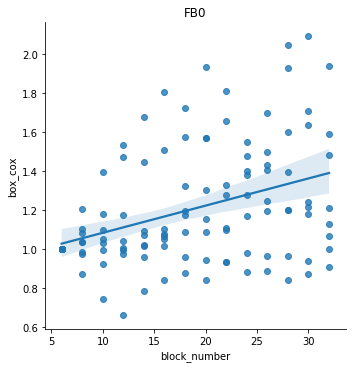

In [121]:
# Linear model plots 
from sklearn import linear_model
sns.lmplot('block_number','env_alpha_norm', data=data[data['fb_type'] == 'FB0'])
plt.title('FB0')
plt.ylabel('box_cox')
plt.xlabel('block_number')

Text(0.5, 6.79999999999999, 'block_number')

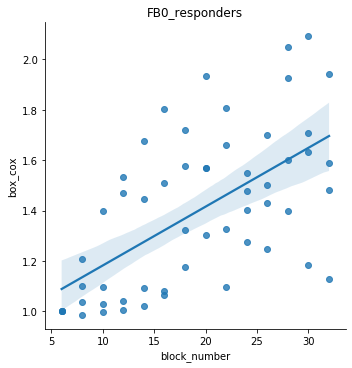

In [122]:
from sklearn import linear_model
sns.lmplot('block_number','env_alpha_norm', data=responder)
plt.title('FB0_responders')
plt.ylabel('box_cox')
plt.xlabel('block_number')

Text(0.5, 6.79999999999999, 'block_number')

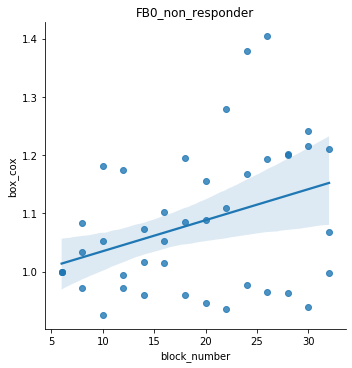

In [123]:
from sklearn import linear_model
sns.lmplot('block_number','env_alpha_norm', data=non_responder)
plt.title('FB0_non_responder')
plt.ylabel('box_cox')
plt.xlabel('block_number')